In [1]:
import os
import h5py
import tqdm
import firedrake 
import numpy as np
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


/Users/bkyanjo3/firedrake/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


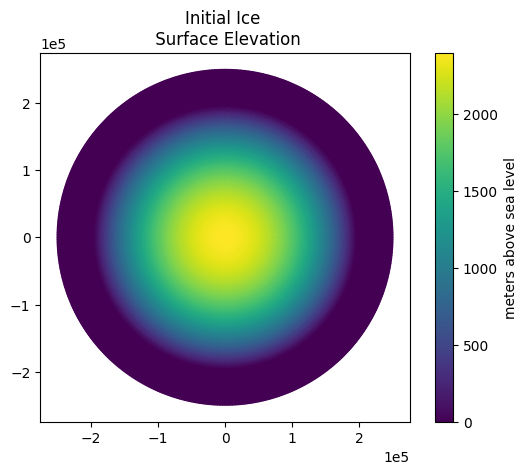

In [2]:
# Geometry
mesh = firedrake.UnitDiskMesh(5)
R = 250e3
mesh.coordinates.dat.data[:] *= R

# input data: ice bed, surface, thickness, velocity, and accumulation rate
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2) 
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

from firedrake import sqrt, exp, Constant, Function
from firedrake import max_value
import icepack.plot

x, y = firedrake.SpatialCoordinate(mesh)
r = sqrt(x**2 + y**2)

# Plateau elevation
b_base = Constant(400)

# Max Elevation
b_max = Constant(1400)

# Radius of the plateau interior
ro = 125e3

# Radius of the ridge
Ro = Constant(200e3)

def tanh(z):
    return (exp(z) - exp(-z))/(exp(z) + exp(-z))

def theta(z):
    return (tanh(z) + 1)/2

def sech(z):
    return 2/(exp(z) + exp(-z))

# make a plateau on which the ice sheet sits
a = Constant(50e3)
eta = (sqrt(x**2 + y**2) - ro)/a

b_expr_plateau = b_base * (1 - theta(3*eta))
b = Function(Q).interpolate(b_expr_plateau)

# Add a ridge that runs along the edge of the plateau
zta = (r- Ro)/a

b_expr_ridge = (b_max - b_base) * sech(3*eta)
b_expr = b_expr_plateau + b_expr_ridge
b = Function(Q).interpolate(b_expr)

# cut valleys into the ridge to get bed topography
rho1 = Constant(1/4)
mu1 = 1- rho1*theta(3 * (x - ro / 4) / a) * sech(2 * y / a)

rho2 = Constant(3/8)
mu2 = 1 - rho2 * theta(3 * (y - ro / 4) / a) * sech(2 * x / a)

rho3 = Constant(1/2)
mu3 = 1 - rho3 * theta(3 * (-x + ro / 4) / a) * sech(2 * y / a)

rho4 = Constant(5/8)
mu4 = 1 - rho4 * theta(3 * (-y + ro / 4) / a) * sech(2 * x / a)

mu = mu1 * mu2 * mu3 * mu4
S = 480/(1-Ro/R)

b_expr_valleys = (b_max - b_base) * sech(3 * eta) * mu - theta(5 * zta) * S*zta
b_expr = b_expr_plateau + b_expr_valleys
b = Function(Q).interpolate(b_expr)


# surface elevation
max_radius = 195e3
dome_height = 2.4e3
dome = dome_height*max_value(1-(x**2 + y**2)/max_radius**2, 0)
s0 = Function(Q).interpolate(dome)

# thickness
h0 = Function(Q).interpolate(max_value(s0 - b, 0))
# print(h0)

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s0, axes=axes)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Initial Ice \n Surface Elevation");

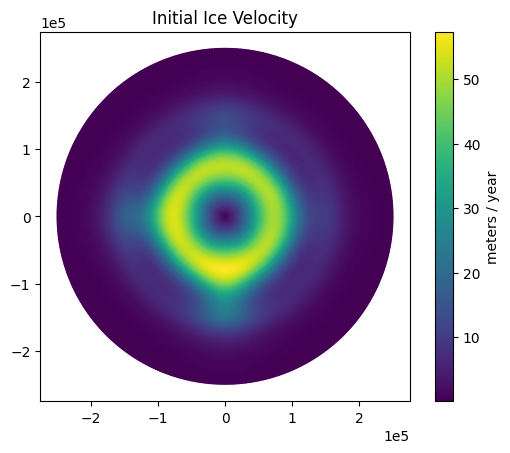

In [3]:
import icepack
model = icepack.models.ShallowIce()

# solve the problem; intializa the flow solver
solver = icepack.solvers.FlowSolver(model) # initialize the flow solver with any argument that never changes throughout the simulation 

# Fluidity factor A
T = Constant(273.15 -5)
A = icepack.rate_factor(T)

# compute the velocity field- call the diagnostic solver
u0 = firedrake.Function(V) # pass in an empty function since we have no initial velocity field
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    surface=s0,
    fluidity=A,
)
# Note: this solver takes in the intial velocity of the ice field, thickness, surface, and fluidity factor as arguments and returns the velocity field

# plot the velocity field
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year")
axes.set_title("Initial Ice Velocity");

In [4]:
from firedrake import min_value
def mass_balance(s,max_a=0.5,da_ds=0.5/1000,ela=300.9):
    return min_value((s-ela)*da_ds, max_a)

ela = 300
max_a = 0 
da_ds = 0

a = mass_balance(s0,ela=ela, max_a=max_a, da_ds=da_ds)

In [28]:
# Utility function to generate restart file names
def get_hdf5_filename(step, restart_dir="restarts"):
    return os.path.join(restart_dir, f"restart_{step}_years.h5")

# Load restart file
def load_restart_file(step):
    print(f"Loading restart file for step {step}...")

    hdf5_file = get_hdf5_filename(step)
    with h5py.File(hdf5_file, 'r') as f:
        dh_max = np.array(f['dh_max'])
        step = int(f['step'][()])
        h_data = f['h'][:]
        u_data = f['u'][:]

    return dh_max, step, h_data, u_data

# Save restart file
def save_restart_file(step, dh_max, h, u):
    print(f"Saving restart file at step {step}...")

    hdf5_file = get_hdf5_filename(step)
    with h5py.File(hdf5_file, 'w') as f:
        f.create_dataset('dh_max', data=dh_max)
        f.create_dataset('step', data=step)
        f.create_dataset('h', data=h.dat.data_ro)  # Save ice thickness as array
        f.create_dataset('u', data=u.dat.data_ro)  # Save velocity as array

In [32]:
# Simulation parameters
dt = 10  # Time step in years
num_years = 400  # Total number of years to simulate
num_timesteps = int(num_years / dt)
save_interval = 50  # Save every 50 years
full_run_flag = 0  # Whether to run the full simulation
bitwise_run_flag = 1  # Whether to run the simulation in bitwise mode

# Restart parameters
restart_flag = 1  # Whether to restart from a previous simulation
save_restarts_flag = 1  # Whether to save restart files
added_time = 200 # Add 100 years to the simulation
new_time = num_years + added_time
new_timesteps = int(new_time / dt)
restart_dir = "restarts"  # Directory to save the restart files

In [33]:
# Ensure restart directory exists
os.makedirs(restart_dir, exist_ok=True)
    
latest_restart = None
restart_files = sorted(os.listdir(restart_dir)) if os.path.exists(restart_dir) else []
if restart_files:
    latest_restarts = []
    for i in range(len(restart_files)):
        lr = int(restart_files[i].split('_')[1])  
        latest_restarts.append(lr)

    latest_restart = max(latest_restarts)

# override the last restart file
latest_restart = latest_restart #choose the latest restart file

if not save_restarts_flag:  os.system("rm -rf restarts")

# Initialize or load from the latest restart file
if latest_restart and restart_flag and added_time > 0:
    num_timesteps = new_timesteps # update the number of timesteps
    dh_max, step, h_data, u_data = load_restart_file(latest_restart)
    hfun = Function(Q)  # Rebuild the Function object for thickness
    ufun = Function(V)  # Rebuild the Function object for velocity
    h.dat.data[:] = h_data  # Assign the loaded data to the Function
    u.dat.data[:,:] = u_data[:, :]
    dh_max_restart = np.array(dh_max[:-1])
    print(f"Restarting from year {latest_restart}")
elif full_run_flag:
    global dh_max_full
    # If no restart, start from the beginning
    full_time = num_years + added_time
    num_timesteps = int(full_time / dt)
    dh_max_full = np.zeros(num_timesteps) * np.nan  # Initialize dh_max array
    step = 0  # Start from the beginning
    h = h0.copy(deepcopy=True)  # Initialize ice thickness from the initial condition
    u = solver.diagnostic_solve(
        velocity=u0,
        thickness=h,
        surface=s0,
        fluidity=A,
    )
    print("Starting from the beginning")
elif bitwise_run_flag:
    dh_max = np.zeros(num_timesteps) * np.nan  # Initialize dh_max array
    step = 0  # Start from the beginning
    h = h0.copy(deepcopy=True)  # Initialize ice thickness from the initial condition
    u = solver.diagnostic_solve(
        velocity=u0,
        thickness=h,
        surface=s0,
        fluidity=A,
    )
    print("Starting from the beginning and running in bitwise mode")


# Initialize accumulation
a = Function(Q)

# Main simulation loop (either from step 0 or from the last saved step)
for step in tqdm.trange(step, num_timesteps):
    h_old = h.copy(deepcopy=True)  # Save the old thickness

    # Prognostic solve (updating ice thickness)
    h = solver.prognostic_solve(
        dt,
        thickness=h,
        accumulation=a,
        velocity=u,
    )

    # Interpolate the thickness
    h.interpolate(max_value(h, 0))
    s = Function(Q).interpolate(b + h)

    # Diagnostic solve (updating velocity)
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
    )

    # Update accumulation (mass balance)
    a.interpolate(mass_balance(s, ela=ela, max_a=max_a, da_ds=da_ds))

    # Calculate dh and track max dh values
    dh = Function(Q).interpolate(h - h_old)
    if restart_flag and added_time > 0:
         dh_max_restart = np.append(dh_max_restart, dh.dat.data_ro.max())
    elif full_run_flag:
        dh_max_full[step] = dh.dat.data_ro.max()
    elif bitwise_run_flag:
        dh_max[step] = dh.dat.data_ro.max()

    # Save restart file every 50 years or when simulation is done
    restart_save_flag = (step + 1) % (save_interval / dt) == 0 or step == num_timesteps - 1
    if save_restarts_flag and restart_save_flag:
        if restart_flag and added_time > 0:
            save_restart_file(step, dh_max_restart, h, u)
        else:
            save_restart_file(step, dh_max, h, u)


Loading restart file for step 39...
Restarting from year 39


  5%|▍         | 1/21 [00:00<00:04,  4.71it/s]

Saving restart file at step 39...


 29%|██▊       | 6/21 [00:01<00:03,  4.86it/s]

Saving restart file at step 44...


 52%|█████▏    | 11/21 [00:02<00:02,  4.85it/s]

Saving restart file at step 49...


 76%|███████▌  | 16/21 [00:03<00:01,  4.47it/s]

Saving restart file at step 54...


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]

Saving restart file at step 59...


Text(0.5, 1.0, 'Max Change in Ice Thickness at each Time Step')

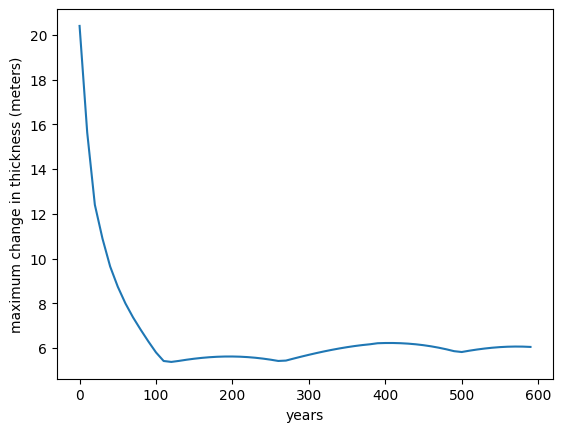

In [34]:
# If we plot the maximum change in thickness through time, we can see how the ice sheet is approaching steady state.
# if restart_flag and added_time > 0:
#     dh_max = dh_max_restart

if restart_flag and added_time > 0:   
    plt.figure()
    plt.plot(dt * np.arange(num_timesteps), dh_max_restart)
elif full_run_flag:
    plt.figure()
    plt.plot(dt * np.arange(num_timesteps), dh_max_full)
elif bitwise_run_flag:
    plt.figure()
    plt.plot(dt * np.arange(num_timesteps), dh_max)
    
plt.xlabel("years")
plt.ylabel("maximum change in thickness (meters)")
axes.set_title("Max Change in Ice Thickness at each Time Step")

In [36]:
# plot the error between restarted and non-restarted simulation
if restart_flag and added_time > 0:
    # Calculate the RMS error between the full and restarted simulations
    rms_error = np.sqrt(np.mean((dh_max_full - dh_max_restart)**2))
    print(f"RMS error between full and restarted simulations: {rms_error:.2e}")
    # Calculate the maximum absolute error between the full and restarted simulations
    max_error = np.max(np.abs(dh_max_full - dh_max_restart))
    print(f"Max absolute error between full and restarted simulations: {max_error:.2e}")

RMS error between full and restarted simulations: 2.38e-02
Max absolute error between full and restarted simulations: 8.26e-02
